In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [110]:
df = pd.read_csv(r"E:\projects\IBM_intern\adult 3.csv")

In [111]:
df.head(5)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [113]:
df.dtypes

age                 int64
workclass          object
fnlwgt              int64
education          object
educational-num     int64
marital-status     object
occupation         object
relationship       object
race               object
gender             object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
income             object
dtype: object

In [114]:
unique_counts = [(col, df[col].nunique()) for col in df.columns]
print(unique_counts)

[('age', 74), ('workclass', 9), ('fnlwgt', 28523), ('education', 16), ('educational-num', 16), ('marital-status', 7), ('occupation', 15), ('relationship', 6), ('race', 5), ('gender', 2), ('capital-gain', 123), ('capital-loss', 99), ('hours-per-week', 96), ('native-country', 42), ('income', 2)]


DATA CLEANING

In [115]:
def remove_rows(df, column, values_to_remove):
    return df[~df[column].isin(values_to_remove)]

In [116]:
df_cleaned=remove_rows(df,'workclass',['Without-pay','Never-worked'])
df_cleaned=remove_rows(df,'education',['5th-6th','1st-4th','Preschool'])

In [117]:
df_cleaned.shape

(48003, 15)

In [118]:
# Identify rows with any "?" in any column
rows_with_qmark = df_cleaned.apply(lambda row: row.astype(str).str.contains(r'\?')).any(axis=1)

# Drop them
df_cleaned_1 = df_cleaned[~rows_with_qmark].reset_index(drop=True)

print(f"Removed {rows_with_qmark.sum()} rows containing '?'.")
print(f"Remaining dataset size: {df_cleaned_1.shape}")

Removed 3524 rows containing '?'.
Remaining dataset size: (44479, 15)


In [119]:
def remove_age_inconsistent_rows(df):
    # Make a copy so original isn't altered
    df = df.copy()
    # Rules: Drop rows with age too low for education level
    edu_high = ['Bachelors', 'Masters', 'Doctorate', 'Assoc-voc', 'Assoc-acdm', 'Prof-school']
    df = df[~((df['age'] < 18) & (df['education'].isin(edu_high)))]
    # Rules: Drop rows with unrealistic marital status for minors
    married_statuses = [
        'Married-civ-spouse', 'Divorced', 'Separated', 'Widowed',
        'Married-spouse-absent', 'Married-AF-spouse'
    ]
    df = df[~((df['age'] < 16) & (df['marital-status'].isin(married_statuses)))]
    # Rules: Drop rows with high-skill occupations for minors
    skilled_jobs = [
        'Exec-managerial', 'Prof-specialty', 'Protective-serv',
        'Tech-support', 'Machine-op-inspct'
    ]
    df = df[~((df['age'] < 18) & (df['occupation'].isin(skilled_jobs)))]
    # Rules: Drop rows with adult relationship roles for minors
    adult_roles = ['Husband', 'Wife', 'Other-relative']
    df = df[~((df['age'] < 16) & (df['relationship'].isin(adult_roles)))]
    # Reset index after removal
    df.reset_index(drop=True, inplace=True)
    return df

In [120]:
df_cleaned_2 = remove_age_inconsistent_rows(df_cleaned_1)

In [121]:
df_cleaned_2.shape

(44452, 15)

In [122]:
def clean_outliers_and_missing(df):
    df = df.copy()
    ### 3. Drop hours-per-week < 1 or > 100 (edge-case outliers)
    df = df[(df['hours-per-week'] >= 1) & (df['hours-per-week'] <= 100)]
    ### 4. Clip capital-gain and capital-loss at 99.5th percentile
    gain_cap = df['capital-gain'].quantile(0.995)
    loss_cap = df['capital-loss'].quantile(0.995)
    df['capital-gain'] = df['capital-gain'].clip(upper=gain_cap)
    df['capital-loss'] = df['capital-loss'].clip(upper=loss_cap)
    df.reset_index(drop=True, inplace=True)
    return df

In [123]:
df_cleaned_3 = clean_outliers_and_missing(df_cleaned_2)

In [124]:
df_cleaned_3.shape

(44452, 15)

In [125]:
def normalize_categorical_text(df):
    df = df.copy()
    cat_cols = df.select_dtypes(include='object').columns

    for col in cat_cols:
        df[col] = df[col].str.strip().str.lower()

    print(f"Normalized {len(cat_cols)} categorical columns: stripped whitespace & lowercased.")
    return df

In [126]:
def check_unexpected_floats(df):
    float_cols = ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'fnlwgt']
    invalid_rows = {}

    for col in float_cols:
        # Check for non-integer values
        mask = df[col] % 1 != 0
        count = mask.sum()
        if count > 0:
            invalid_rows[col] = count

    if invalid_rows:
        print("Columns with unexpected float values:")
        for col, count in invalid_rows.items():
            print(f" - {col}: {count} rows")
    else:
        print("All numeric columns are clean (integer only).")

In [127]:
df_cleaned_4=normalize_categorical_text(df_cleaned_3)

Normalized 9 categorical columns: stripped whitespace & lowercased.


In [22]:
check_unexpected_floats(df_cleaned_4)

All numeric columns are clean (integer only).


In [140]:
mapped_data = dict(zip(mapping['education'], mapping['educational-num']))
for key in mapped_data :
    print(key)

7th-8th
9th
10th
11th
12th
hs-grad
some-college
assoc-voc
assoc-acdm
bachelors
masters
prof-school
doctorate


In [23]:
df_cleaned_4.drop(columns=['education'], inplace=True)
df_cleaned_4.drop(columns=['capital-gain'], inplace=True)
df_cleaned_4.drop(columns=['capital-loss'], inplace=True)

In [24]:
df_cleaned_4['income'].value_counts(normalize=True)

income
<=50k    0.74856
>50k     0.25144
Name: proportion, dtype: float64

In [25]:
df_cleaned_4.head(5)

,age,workclass,fnlwgt,educational-num,marital-status,occupation,relationship,race,gender,hours-per-week,native-country,income
0,25,private,226802,7,never-married,machine-op-inspct,own-child,black,male,40,united-states,<=50k
1,38,private,89814,9,married-civ-spouse,farming-fishing,husband,white,male,50,united-states,<=50k
2,28,local-gov,336951,12,married-civ-spouse,protective-serv,husband,white,male,40,united-states,>50k
3,44,private,160323,10,married-civ-spouse,machine-op-inspct,husband,black,male,40,united-states,>50k
4,34,private,198693,6,never-married,other-service,not-in-family,white,male,30,united-states,<=50k


In [26]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [27]:
df=df_cleaned_4.copy()

In [28]:
cat_cols = [
    'workclass',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'gender',
    'native-country',
    'income'
]

# Apply label encoding to each categorical column
for col in cat_cols:
    df[col] = df[col].astype('category').cat.codes

In [29]:
df.head(5)

,age,workclass,fnlwgt,educational-num,marital-status,occupation,relationship,race,gender,hours-per-week,native-country,income
0,25,2,226802,7,4,6,3,2,1,40,38,0
1,38,2,89814,9,2,4,0,4,1,50,38,0
2,28,1,336951,12,2,10,0,4,1,40,38,1
3,44,2,160323,10,2,6,0,2,1,40,38,1
4,34,2,198693,6,4,7,1,4,1,30,38,0


In [30]:
scaler = MinMaxScaler()
df['fnlwgt'] = scaler.fit_transform(df[['fnlwgt']])

# Stratified split of features and target
X = df.drop('income', axis=1)
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [31]:
# Count number of 0s and 1s in y
print(y.value_counts())

income
0    33275
1    11177
Name: count, dtype: int64


In [32]:
# Store normalized fnlwgt for training set, and drop from features
train_fnlwgt = X_train['fnlwgt'].reset_index(drop=True)
X_train = X_train.drop(['fnlwgt'], axis=1).reset_index(drop=True)

# Drop fnlwgt from test set (you can store if you want for analysis, but not used in prediction)
test_fnlwgt = X_test['fnlwgt'].reset_index(drop=True)
X_test = X_test.drop(['fnlwgt'], axis=1).reset_index(drop=True)



In [33]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE only on training features (excluding weights), and on the labels
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [34]:
# Count number of 0s and 1s in y
print(y_train_smote.value_counts())

income
1    26620
0    26620
Name: count, dtype: int64


In [35]:
# Ensure both y_train and train_fnlwgt are aligned
y_train = y_train.reset_index(drop=True)
train_fnlwgt = train_fnlwgt.reset_index(drop=True)

# 1. Calculate how many new (synthetic) samples were generated
n_new = len(X_train_smote) - len(train_fnlwgt)

# 2. Compute the mean fnlwgt for the original minority class
minority_class = y_train.value_counts().idxmin()
minority_class_indices = y_train == minority_class

# Now indexing will work since both Series have matching indices
mean_fnlwgt_minority = train_fnlwgt[minority_class_indices].mean()

# 3. Extend the weights with mean/minority weights for synthetic samples
synthetic_weights = pd.Series([mean_fnlwgt_minority] * n_new)

# 4. Combine original and synthetic weights
fnlwgt_combined = pd.concat([train_fnlwgt, synthetic_weights], ignore_index=True)

# 5. Add fnlwgt as a new column to X_train_smote
X_train_smote = X_train_smote.reset_index(drop=True)
X_train_smote['fnlwgt'] = fnlwgt_combined.values

# 6. Combine features, weights, and target into one DataFrame
trained_full = X_train_smote.copy()

# Ensure y_train_smote is aligned too
trained_full['y'] = y_train_smote.reset_index(drop=True)

# 7. Shuffle the complete dataset
trained_full = trained_full.sample(frac=1, random_state=42).reset_index(drop=True)

# 8. Final balanced dataframe
df_balanced = trained_full.copy()

# View top 5 rows
df_balanced.head(5)


,age,workclass,educational-num,marital-status,occupation,relationship,race,gender,hours-per-week,native-country,fnlwgt,y
0,18,2,7,4,7,3,4,0,6,38,0.095828,0
1,51,3,13,0,4,4,4,1,50,38,0.228712,0
2,51,2,13,2,11,0,4,1,60,38,0.041806,0
3,38,2,9,2,13,0,4,1,55,38,0.118225,1
4,24,2,9,4,7,1,4,1,37,38,0.057046,0


In [36]:
print("\nIncome value counts after mapping:")
print(df_balanced['y'].value_counts(dropna=False))


Income value counts after mapping:
y
0    26620
1    26620
Name: count, dtype: int64


In [37]:
# Separate sample weights
train_weights = df_balanced.pop('fnlwgt')

# Separate output labels
y_balanced = df_balanced.pop('y')

# The remaining columns are your feature set
X_balanced = df_balanced

test_weights = test_fnlwgt.copy()

In [38]:
# (Optional) Check dimensions
print("TRAINING SET")
print(f'Features shape: {X_balanced.shape}')
print(f'Labels shape: {y_balanced.shape}')
print(f'Weights shape: {train_weights.shape}')
print("-"*50)
print("TESTING SET")
print(f'Features shape:{X_test.shape}')
print(f'Labels shape: {y_test.shape}')
print(f'Weights shape: {test_weights.shape}')

TRAINING SET
Features shape: (53240, 10)
Labels shape: (53240,)
Weights shape: (53240,)
--------------------------------------------------
TESTING SET
Features shape:(8891, 10)
Labels shape: (8891,)
Weights shape: (8891,)


In [39]:
X_train,y_train=X_balanced.copy(),y_balanced.copy()

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import classification_report

In [41]:
# 1. Separate features, labels, and weights from your final balanced data
X_train = X_balanced.copy()
y_train = y_balanced.copy()
sample_weights = train_weights.copy()

# Drop weights column from features if it exists
if 'fnlwgt' in X_train.columns:
    X_train = X_train.drop(columns=['fnlwgt'])

# 2. Define models to train
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

# 3. Train each model and print classification reports
for name, model in models.items():
    print(f"\n{'='*20} {name} {'='*20}")
    
    # Fit the model using sample weights
    model.fit(X_train, y_train, sample_weight=sample_weights)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Print classification report
    print(classification_report(y_test, y_pred))



==================== Decision Tree ====================
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      6655
           1       0.52      0.64      0.57      2236

    accuracy                           0.76      8891
   macro avg       0.69      0.72      0.70      8891
weighted avg       0.78      0.76      0.77      8891


==================== Random Forest ====================
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      6655
           1       0.58      0.68      0.62      2236

    accuracy                           0.79      8891
   macro avg       0.73      0.76      0.74      8891
weighted avg       0.81      0.79      0.80      8891


==================== XGBoost ====================
              precision    recall  f1-score   support

           0       0.92      0.80      0.85      6655
           1       0.57      0.79      0.66      2236

    accuracy     

In [42]:
from sklearn.model_selection import GridSearchCV

In [43]:
# Define parameter grids
param_grids = {
    "Decision Tree": {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    "Random Forest": {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    "XGBoost": {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2]
    }
}

# Define models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

# Drop 'fnlwgt' if present
if 'fnlwgt' in X_train.columns:
    X_train_tune = X_train.drop(columns=['fnlwgt'])
else:
    X_train_tune = X_train.copy()

# Run GridSearch for each model
for name, model in models.items():
    print(f"\n{'='*20} Tuning {name} {'='*20}")

    grid = GridSearchCV(estimator=model,
                        param_grid=param_grids[name],
                        cv=3,
                        scoring='f1',
                        n_jobs=-1,
                        verbose=1)
    
    # Fit with sample weights if applicable
    if name in ["Decision Tree", "Random Forest"]:
        grid.fit(X_train_tune, y_train, sample_weight=sample_weights)
    else:
        grid.fit(X_train_tune, y_train, sample_weight=sample_weights)
    
    # Best parameters
    print(f"Best parameters for {name}: {grid.best_params_}")
    
    # Predict on test set
    y_pred = grid.best_estimator_.predict(X_test)
    
    # Classification report
    print(f"Classification Report for {name} after tuning:")
    print(classification_report(y_test, y_pred))



==================== Tuning Decision Tree ====================
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for Decision Tree: {'max_depth': 20, 'min_samples_split': 2}
Classification Report for Decision Tree after tuning:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      6655
           1       0.52      0.71      0.60      2236

    accuracy                           0.76      8891
   macro avg       0.71      0.75      0.72      8891
weighted avg       0.80      0.76      0.77      8891


==================== Tuning Random Forest ====================
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Classification Report for Random Forest after tuning:
              precision    recall  f1-score   support

           0       0.91      0.81      0.86      6655
           1       0.57      0.

In [44]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.2, 0.4, 1],
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [1, 1.5, 2], # L2 regularization
}

In [45]:
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,             # Number of parameter combinations to try
    scoring='f1',          # or 'roc_auc', 'accuracy', etc.
    n_jobs=-1,
    cv=5,
    verbose=1,
    random_state=42
)

# Pass sample weights during fitting
random_search.fit(X_train, y_train, sample_weight=train_weights)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.2, 0.4, 1],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [100, 200, 300, 400],
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [1, 1.5, 2],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='f1', verbose=1)

In [46]:
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train, sample_weight=train_weights)
y_pred = best_model.predict(X_test)

# Evaluate
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86      6655
           1       0.58      0.78      0.66      2236

    accuracy                           0.80      8891
   macro avg       0.75      0.79      0.76      8891
weighted avg       0.83      0.80      0.81      8891

ROC AUC: 0.876484149139348


In [47]:
from sklearn.metrics import precision_recall_curve, f1_score

In [48]:
# Get probabilities
y_probs = best_model.predict_proba(X_test)[:, 1]

# Calculate precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Calculate F1 for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)

# Find threshold that maximizes F1
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best threshold for max F1: {best_threshold}")

# Predict using optimal threshold
y_pred_optimal = (y_probs >= best_threshold).astype(int)

# Evaluate
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_pred_optimal))
print("ROC AUC:", roc_auc_score(y_test, y_probs))

Best threshold for max F1: 0.5158901810646057
              precision    recall  f1-score   support

           0       0.91      0.82      0.86      6655
           1       0.58      0.77      0.66      2236

    accuracy                           0.80      8891
   macro avg       0.75      0.79      0.76      8891
weighted avg       0.83      0.80      0.81      8891

ROC AUC: 0.876484149139348


In [49]:
X_test.head(5)

,age,workclass,educational-num,marital-status,occupation,relationship,race,gender,hours-per-week,native-country
0,37,2,9,2,2,0,4,1,45,38
1,49,2,13,2,2,0,4,1,40,38
2,44,2,9,0,11,1,4,1,60,38
3,47,4,9,0,7,1,4,0,48,21
4,46,2,12,2,2,0,4,1,40,38


In [50]:
import joblib

# Save the trained model
joblib.dump(best_model, "xgb_best_model.pkl")

['xgb_best_model.pkl']

In [51]:
with open("xgb_best_threshold.txt", "w") as f:
    f.write(str(best_threshold))

In [71]:
import joblib
import numpy as np

def predict_manual_input(input_features, model_path="xgb_best_model.pkl", threshold_path="xgb_best_threshold.txt"):
    """
    Predicts class based on manual input features using the saved model and threshold.
    
    Parameters:
    - input_features: list or array-like of feature values in the same order as training
    - model_path: str, path to the saved model
    - threshold_path: str, path to the saved threshold
    
    Returns:
    - predicted_class: int (0 or 1)
    - probability: float (probability of class 1)
    """
    # Load model
    model = joblib.load(model_path)

    # Load threshold
    with open(threshold_path, "r") as f:
        threshold = float(f.read())

    # Convert input to 2D array
    input_array = np.array(input_features).reshape(1, -1)

    # Predict probability
    prob = model.predict_proba(input_array)[0, 1]

    # Apply threshold
    prediction = int(prob >= threshold)

    # Print result
    print(f"Predicted Class: {prediction} (1=Positive, 0=Negative)")
    print(f"Probability of Class 1: {prob:.4f}")
    print(f"Used Threshold: {threshold:.4f}")
    
    return prediction, prob

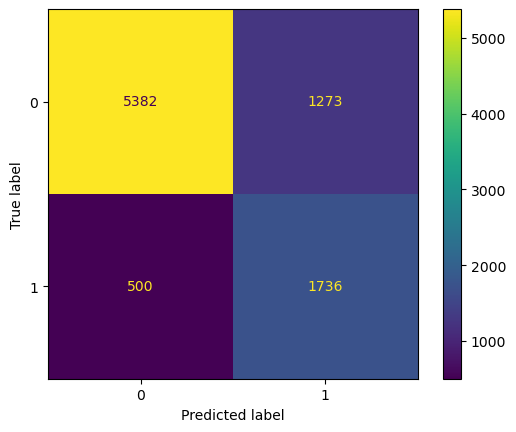

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

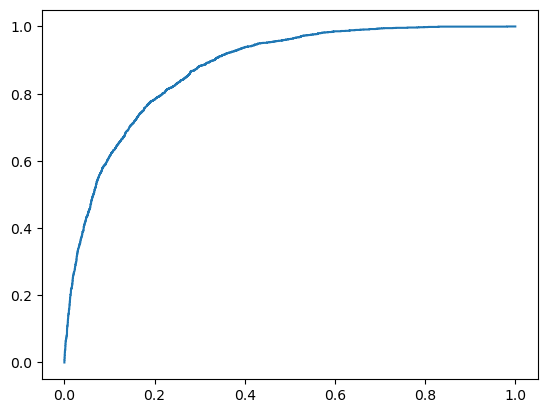

In [57]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr)

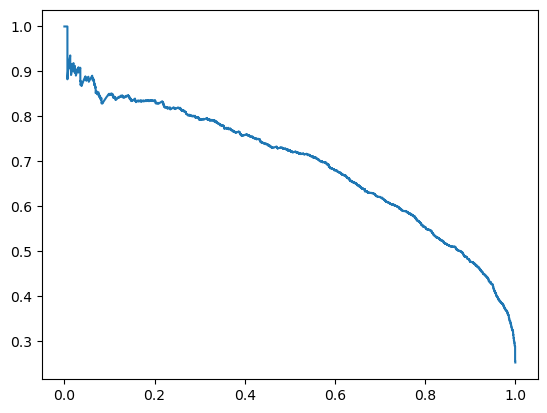

In [58]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
plt.plot(recall, precision)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

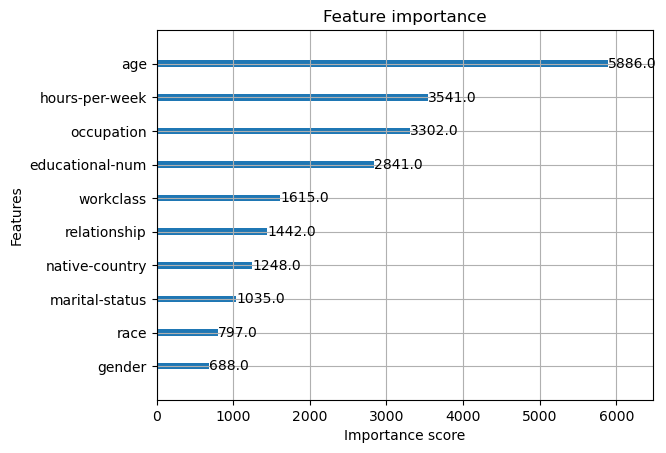

In [59]:
from xgboost import plot_importance
plot_importance(best_model)

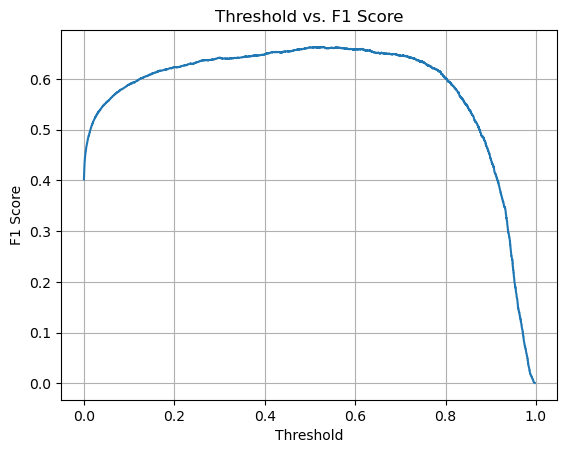

In [60]:
plt.plot(thresholds, f1_scores[:-1])  # trim the last F1 score
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("Threshold vs. F1 Score")
plt.grid(True)
plt.show()